In [71]:
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
from typing import List # typing makes python recognize documentation

class Body:
    def __init__(self, name, mass, x_vec, v_vec, has_units = True):
        self.name = name
        self.has_units = has_units
        if self.has_units:
            self.mass = mass.cgs
            self.x_vec = x_vec.cgs.value
            self.v_vec = v_vec.cgs.value
        else:
            self.mass = mass
            self.x_vec = x_vec
            self.v_vec = v_vec

    def return_y_vec(self): # if something is a method, you always need to use self
        return np.concatenate((self.x_vec, self.v_vec))

    def return_mass(self):
        if self.has_units:
            return self.mass.cgs.value
        else:
            return self.mass

    def return_name(self):
        return self.name


class Simulation:
    def __init__(self, bodies: List[Body], has_units=True):
        self.has_units = has_units
        self.bodies = bodies
        self.n_bodies = len(self.bodies)
        self.dim = 6.0
        self.quant_vec = np.concatenate(np.array([i.return_y_vec() for i in self.bodies])) # list comprehension
        self.mass_vec = np.array([i.return_mass() for i in self.bodies])
        self.name_vec = [i.return_name() for i in self.bodies]

        self.diff_eq_kwargs = None
        self.calc_diff_eqs = None

        self.history = np.array([])


    # 1st Method - Setter Method: Set differential equations
    def set_diff_eqs(self, calc_diff_eqs, **kwargs):
        self.diff_eq_kwargs = kwargs
        self.calc_diff_eqs = calc_diff_eqs

    # 2nd Method - RK4 (Range-Kutta Method): Estimating the curve of an equation
    def rk4(self, t, dt): # t is time, dt is change in time
        k1 = dt*self.calc_diff_eqs(t, self.quant_vec, self.mass_vec, **self.diff_eq_kwargs)
        k2 = dt*self.calc_diff_eqs(t+0.5*dt, self.quant_vec+0.5*k1, self.mass_vec, **self.diff_eq_kwargs)
        k3 = dt*self.calc_diff_eqs(t+0.5*dt, self.quant_vec+0.5*k2, self.mass_vec, **self.diff_eq_kwargs)
        k4 = dt*self.calc_diff_eqs(t+dt, self.quant_vec+k3, self.mass_vec, **self.diff_eq_kwargs)
        y_new = self.quant_vec+((k1+(2*k2)+(2*k3)+k4)/6.0)
        return y_new

    # 3rd Method - Run: Runs the simulation
    def run(self, T, dt, t0=0):
        if not hasattr(self, 'calc_diff_eqs'):
            raise AttributeError('You must set a diff eq solver first.')
        if self.has_units:
            try:
                _ =  t0.unit
            except:
                t0=(t0*T.unit).cgs.value
            T = T.cgs.value
            dt = dt.cgs.value

            self.history = [self.quant_vec]
            clock_time = t0
            nsteps = int((T-t0)/dt)
            start_time = time.time()
            for step in range(nsteps):
                sys.stdout.flush()
                sys.stdout.write('Integrating: step = {} /  {} | simulation time = {}'. format(step, nsteps, round(clock_time,3)) + '\r')
                y_new = self.rk4(0,dt)
                self.history.append(y_new)
                self.quant_vec = y_new
                clock_time += dt
            runtime = time.time() - start_time
            print('\n')
            print('Simulation completed in in {} seconds'.format(runtime))
            self.history = np.array(self.history)

    # 4th function - Acceleration Calculator: Calculates the acceleration between the different bodies
    # in the simulation at each interval of time
def nbody_solve(t, y, masses):
    N_bodies = int(len(y) / 6)
    solved_vector = np.zeros(y.size)
    for i in range(N_bodies): # i is the number of the body we are checking (e.g. for Earth, i = 0)
        ioffset = i*6
        for j in range(N_bodies): # comparing 2 bodies so need second value
            joffset = j*6
            solved_vector[ioffset+0] = y[ioffset+3]
            solved_vector[ioffset+1] = y[ioffset+4]
            solved_vector[ioffset+2] = y[ioffset+5]
            if i != j: # if i=j it means we are checking the same body
                dx = y[ioffset] - y[joffset]
                dy = y[ioffset+1] - y[joffset+1]
                dz = y[ioffset+2] - y[joffset+2]
                r = (dx**2+dy**2+dz**2)**0.5 # radial distance between the bodies
                ax = ((-c.G.cgs * masses[j] / r**3) * dx).value
                ay = ((-c.G.cgs * masses[j] / r**3) * dy).value
                az = ((-c.G.cgs * masses[j] / r**3) * dz).value
                solved_vector[ioffset+3] += ax
                solved_vector[ioffset+4] += ay
                solved_vector[ioffset+5] += az
    return solved_vector


In [72]:
M_moon = (7.347e22*u.kg).cgs
v_moon = np.array([0,1.022,0])*u.km/u.s
moon_momentum = M_moon * v_moon
Moon = Body(mass=M_moon,
           x_vec = np.array([3.84e5,0,0])*u.km,
           v_vec = v_moon,
           name='Moon')


In [73]:
v_earth = - (moon_momentum / c.M_earth).to(u.km/u.s).value
Earth = Body(mass=c.M_earth.cgs,
             x_vec=np.array([0,0,0])*u.km,
             v_vec=np.array(v_earth)*u.km/u.s,
             name='Earth')

In [74]:
bodies = [Earth,Moon]

In [75]:
simulation = Simulation(bodies)
simulation.set_diff_eqs(nbody_solve)

In [76]:
simulation.run(1*u.day,1*u.hr)

Integrating: step = 23 /  24 | simulation time = 82800.0

Simulation completed in in 0.15650105476379395 seconds


In [77]:
print(simulation.history)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  -1.25727109e+03 -0.00000000e+00  3.84000000e+10  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.02200000e+05  0.00000000e+00]
 [ 2.15488844e+04 -4.52610625e+06  0.00000000e+00  1.19715052e+01
  -1.25721303e+03  0.00000000e+00  3.83982484e+10  3.67914337e+08
   0.00000000e+00 -9.73129693e+02  1.02195281e+05  0.00000000e+00]
 [ 8.61934365e+04 -9.05179450e+06  0.00000000e+00  2.39418430e+01
  -1.25703887e+03  0.00000000e+00  3.83929936e+10  7.35794695e+08
   0.00000000e+00 -1.94616450e+03  1.02181123e+05  0.00000000e+00]
 [ 1.93927353e+05 -1.35766468e+07  0.00000000e+00  3.59098464e+01
  -1.25674861e+03  0.00000000e+00  3.83842362e+10  1.10360710e+09
   0.00000000e+00 -2.91900954e+03  1.02157529e+05  0.00000000e+00]
 [ 3.44740129e+05 -1.81002453e+07  0.00000000e+00  4.78743485e+01
  -1.25634230e+03  0.00000000e+00  3.83719771e+10  1.47131759e+09
   0.00000000e+00 -3.89156997e+03  1.02124502e+05  0.00000000e+00]
 [ 5.

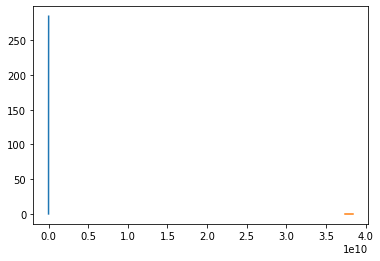

In [78]:
simulation.plot()